In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os


In [2]:
data_root = '/home/bearbalalaika/Desktop/Kaggle/Clean_vs_Dirty/plates'
print(os.listdir(data_root))

['test', 'train', '.DS_Store']


In [3]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 12858.45it/s]


In [4]:
!ls train

cleaned  dirty


In [6]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.2, p=0.1, interpolation=3),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.CenterCrop(180),
        transforms.Resize((224, 224)),
        transforms.ColorJitter(hue=(0.1, 0.2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


val_transforms = transforms.Compose([        
    transforms.RandomPerspective(distortion_scale=0.2, p=0.1, interpolation=3),
    transforms.CenterCrop(180),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=(0.1, 0.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 32
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [5]:
len(train_dataloader), len(train_dataset)

(1, 32)

In [27]:
from tqdm import tqdm

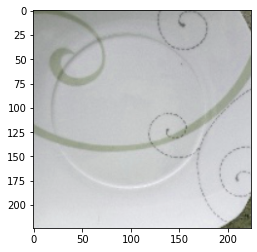

In [7]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

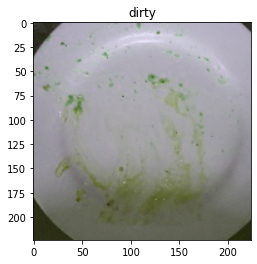

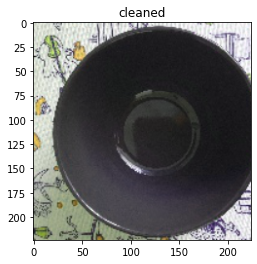

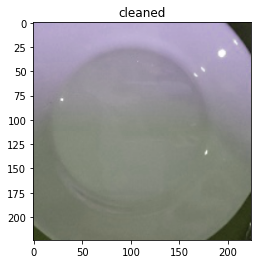

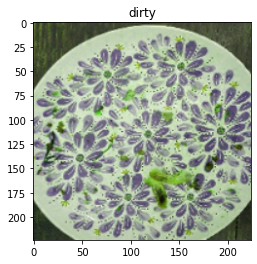

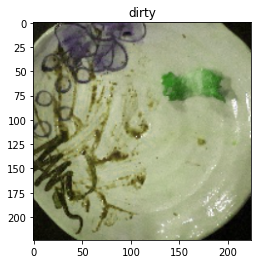

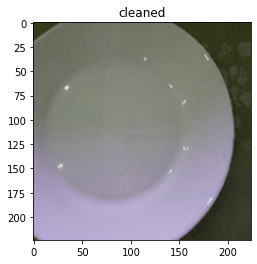

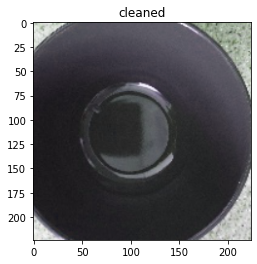

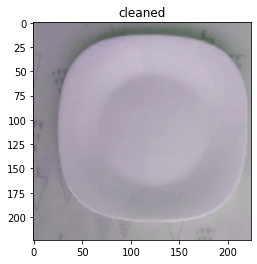

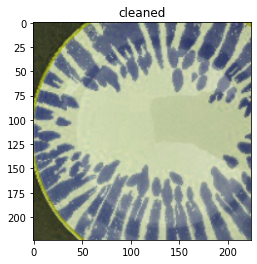

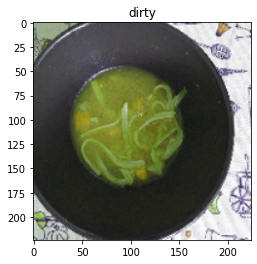

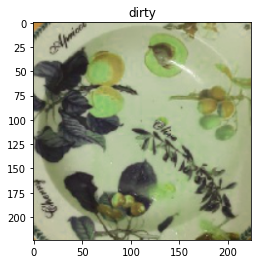

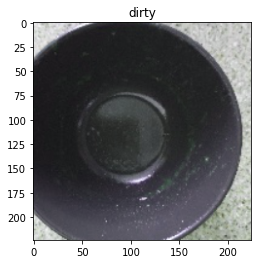

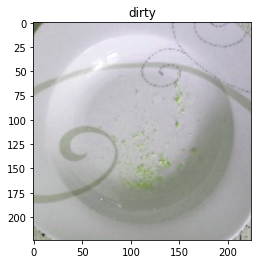

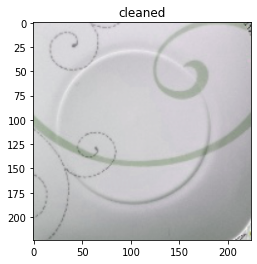

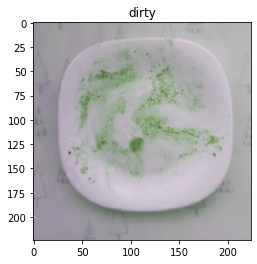

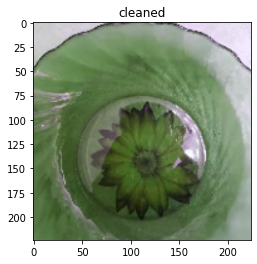

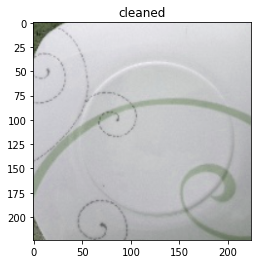

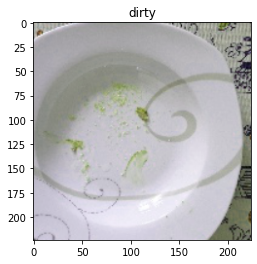

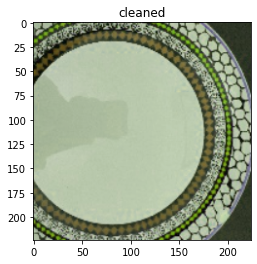

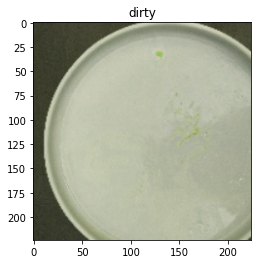

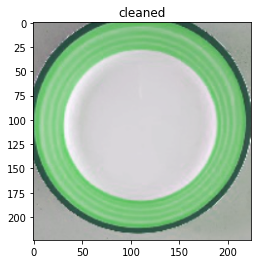

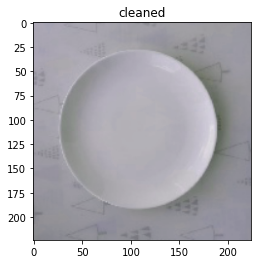

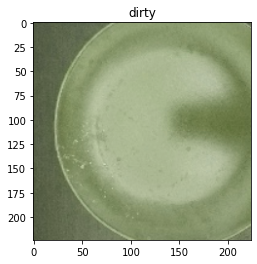

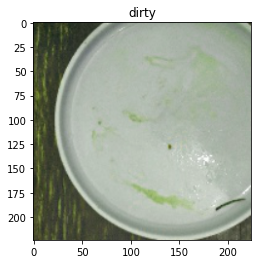

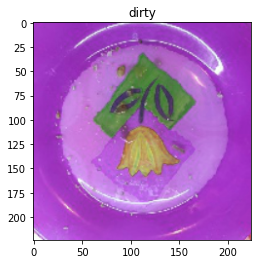

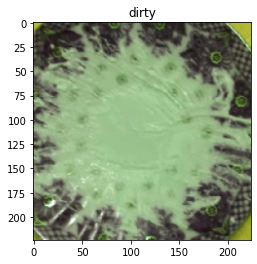

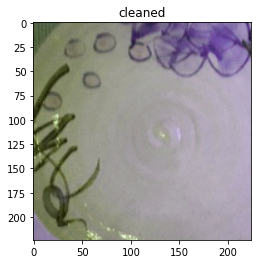

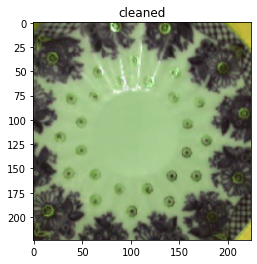

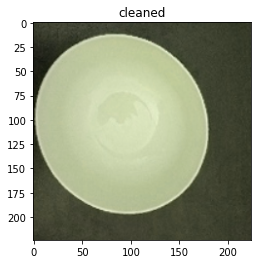

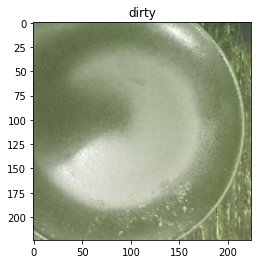

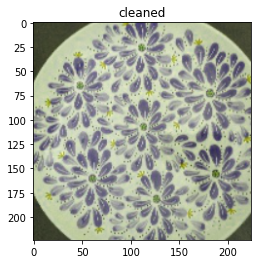

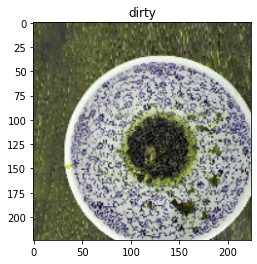

In [8]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [9]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [10]:
from torchvision.models import resnet152


model = models.resnet152(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

#model.fc = torch.nn.Linear(model.fc.in_features, 2)

model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(256, 128), 
    torch.nn.ReLU(),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(128, 2), 
#    torch.nn.LogSoftmax(dim=1)
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5.0e-4)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.05)

In [13]:
train_model(model, loss, optimizer, scheduler, num_epochs=10);

Epoch 0/9:


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

train Loss: 0.6572 Acc: 0.4688



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

val Loss: 0.6167 Acc: 0.8750
Epoch 1/9:



100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

train Loss: 0.5548 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

val Loss: 0.5224 Acc: 1.0000
Epoch 2/9:



100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

train Loss: 0.4713 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

val Loss: 0.3670 Acc: 1.0000
Epoch 3/9:



100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

train Loss: 0.3852 Acc: 1.0000



100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

val Loss: 0.2715 Acc: 1.0000
Epoch 4/9:



100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

train Loss: 0.2516 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

val Loss: 0.2871 Acc: 1.0000
Epoch 5/9:



100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

train Loss: 0.2212 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

val Loss: 0.2684 Acc: 1.0000
Epoch 6/9:



100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

train Loss: 0.2550 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

val Loss: 0.2767 Acc: 1.0000
Epoch 7/9:



100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

train Loss: 0.2448 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

val Loss: 0.2828 Acc: 1.0000
Epoch 8/9:



100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

train Loss: 0.2470 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

val Loss: 0.2947 Acc: 1.0000
Epoch 9/9:



100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

train Loss: 0.2450 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

val Loss: 0.2836 Acc: 1.0000


In [12]:
for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=3.0e-4)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.05)

In [14]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [15]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/home/bearbalalaika/Desktop/Kaggle/Clean_vs_Dirty/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [16]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /home/bearbalalaika/Desktop/Kaggle/Clean_vs_Dirty/test
    StandardTransform
Transform: Compose(
               RandomPerspective(p=0.1)
               CenterCrop(size=(180, 180))
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ColorJitter(brightness=None, contrast=None, saturation=None, hue=(0.1, 0.2))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [16]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


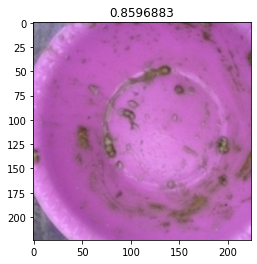

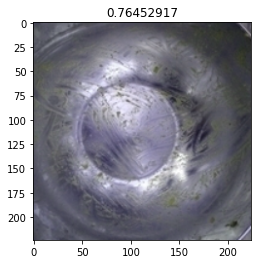

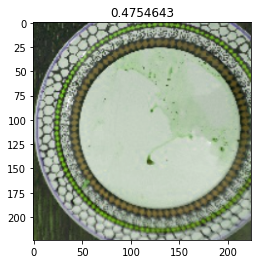

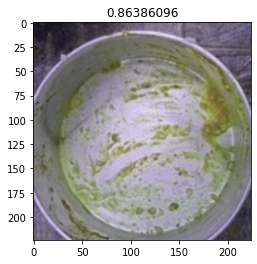

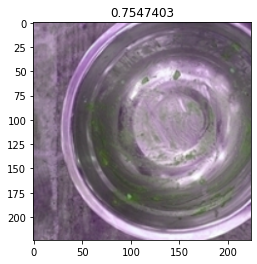

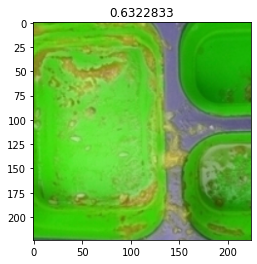

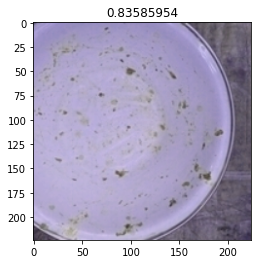

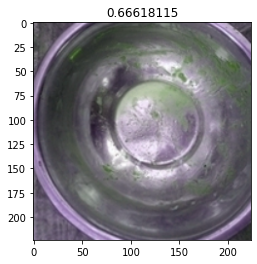

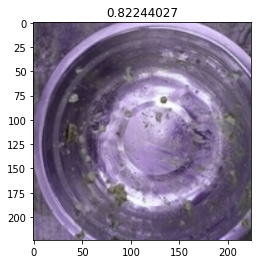

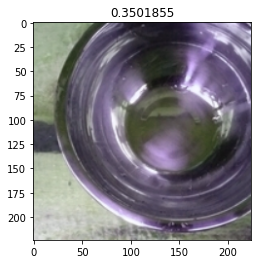

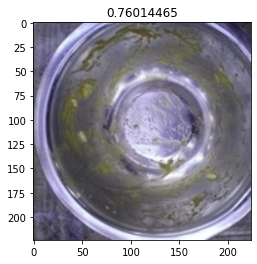

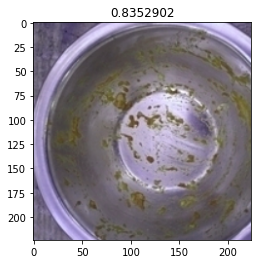

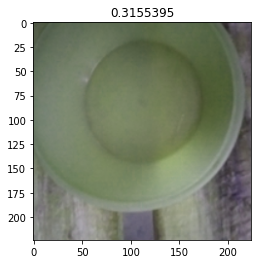

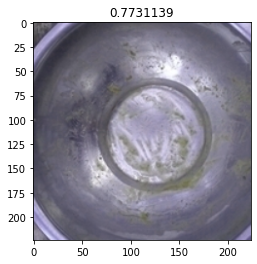

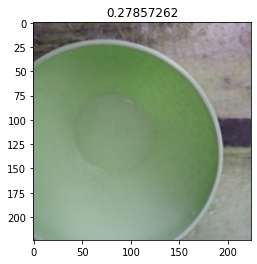

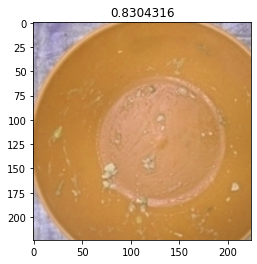

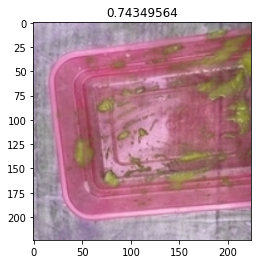

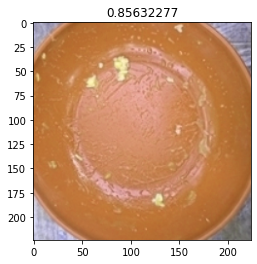

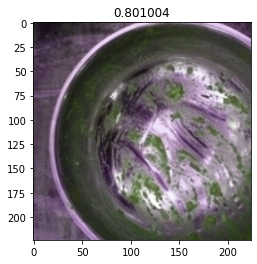

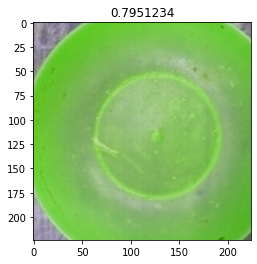

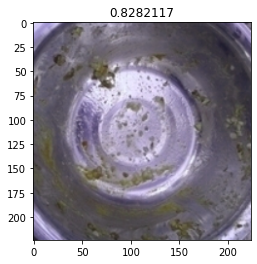

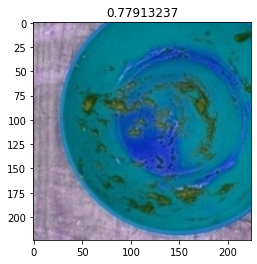

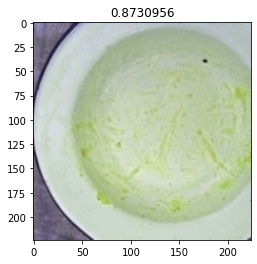

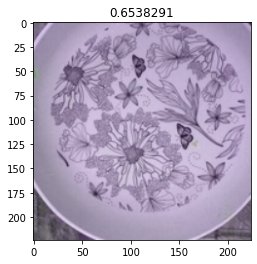

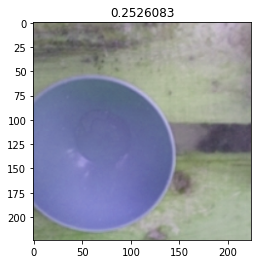

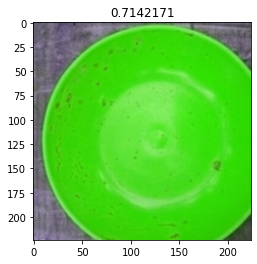

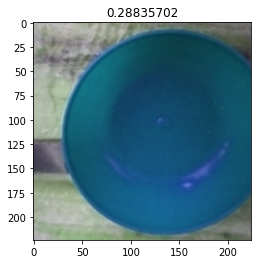

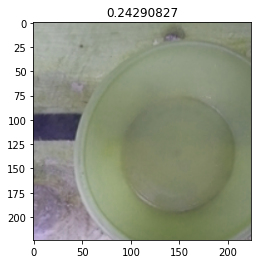

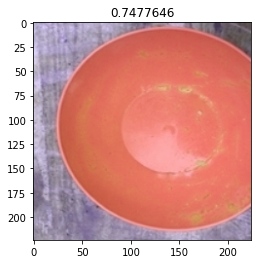

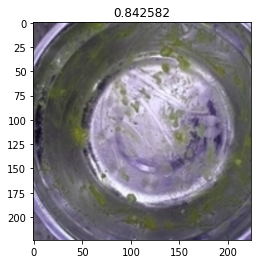

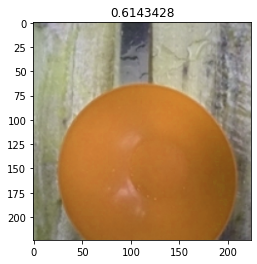

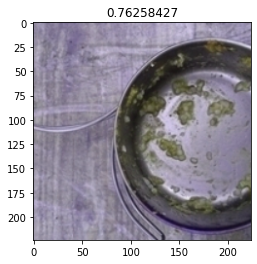

In [17]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [18]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [19]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/home/bearbalalaika/Desktop/Kaggle/Clean_vs_Dirty/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

label
id           
0000    dirty
0001    dirty
0002  cleaned
0003    dirty
0004    dirty
0005    dirty

In [20]:
submission_df.to_csv('submission.csv')

In [21]:
!rm -rf train val test